<a href="https://colab.research.google.com/github/ennbie/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection using brain MRI images

Dataset obtained from : [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DIRECTORY = "./drive/MyDrive/Brain tumor detection/"
DATA_PATH = DIRECTORY + "brain_tumor_dataset/"

## Importing packages

In [3]:
import os
import shutil
import random
import math
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Splitting Dataset into Training, Testing and Validation sets

In [4]:
SEED = 123
train = DIRECTORY + "train/"
test = DIRECTORY + "test/"
validation = DIRECTORY + "validation/"

In [5]:
for path in [train,test,validation]:
  os.makedirs(path + "yes/")
  os.makedirs(path + "no/")

In [6]:
test_examples = train_examples = validation_examples = 0

In [7]:
for yes_no in os.listdir(DATA_PATH):
      n = len(os.listdir(DATA_PATH + yes_no))
      for (i, file_name) in enumerate(os.listdir(DATA_PATH + yes_no)):
          img = DATA_PATH + yes_no + '/' + file_name
          if i < 10:
              shutil.copy(img, test + yes_no + '/' + file_name)
              test_examples += 1
          elif i < 0.85*n:
              shutil.copy(img, train + yes_no + '/' + file_name)
              train_examples += 1
          else:
              shutil.copy(img, validation + yes_no + '/' + file_name)
              validation_examples += 1

In [8]:
print(f"Number of training examples: {train_examples}")
print(f"Number of test examples: {test_examples}")
print(f"Number of validation examples: {validation_examples}")

Number of training examples: 196
Number of test examples: 20
Number of validation examples: 37


## Image Loading and Preprocessing

In [9]:
def load_data(path):
  X=[]
  Y=[]
  for img_file in glob.iglob(path+"yes/*"):
      img = cv2.imread(img_file)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224))
      X.append(img)
      Y.append(1)

  for img_file in glob.iglob(path+"no/*"):
      img = cv2.imread(img_file)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
      X.append(img)
      Y.append(0)

  return np.array(X), np.array(Y)

X_train, Y_train = load_data(train)
X_test, Y_test = load_data(test)
X_val, Y_val = load_data(validation)

## Visualizing Brain MRI Images

1. Plot random images from dataset

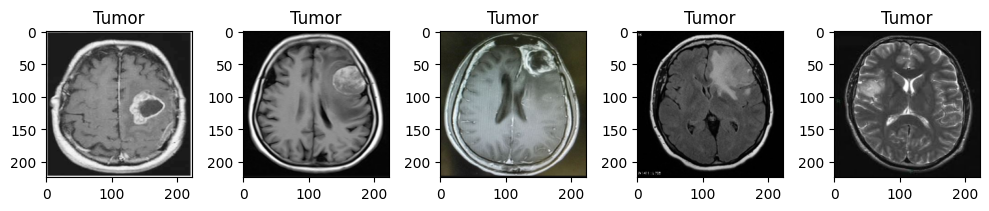

In [10]:
index = np.random.choice(X_train.shape[0], 5, replace=False)
plt.figure(figsize=(10,10))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[index[i]])
    plt.title("Tumor" if Y_train[index[i]] else "Healthy")

plt.tight_layout()
plt.show()

2. Plot examples of images with tumor and without tumor

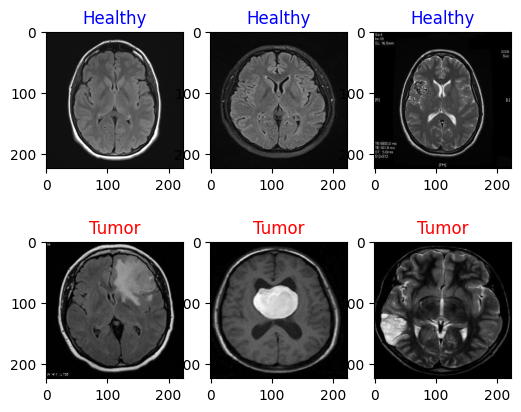

In [11]:
# Define the labels and their corresponding colors
labels = {0: 'Healthy', 1: 'Tumor'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(6, 5))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, Y_train) if y == label][:3]
    for j,img in enumerate(images):
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

## Data Augmentation

In [56]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True,
    seed=SEED
)

val_generator = test_datagen.flow(
    X_val,
    Y_val,
    batch_size=16,
    shuffle=True,
    seed=SEED
)

## Constructing Model using Transfer Learning on VGG16

In [57]:
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(224,224,3)
                  )
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model = Sequential([
    base_model,
    Flatten(name='flatten'),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])
# model.layers[0].trainable = False

In [59]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 14,739,777 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)
# model.compile(loss='binary_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [61]:
# !pip install keras-nightly

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.7, patience = 3, min_delta = 0.001,
                              mode='auto',verbose=1)

In [63]:
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

history = model.fit(
    train_generator,
    epochs=40,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[checkpoint,reduce_lr]
)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6637 - loss: 0.6222
Epoch 1: val_accuracy improved from -inf to 0.78378, saving model to effnet.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6598 - loss: 0.6256 - val_accuracy: 0.7838 - val_loss: 0.5740 - learning_rate: 1.0000e-04
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7558 - loss: 0.5779
Epoch 2: val_accuracy did not improve from 0.78378
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - accuracy: 0.7551 - loss: 0.5727 - val_accuracy: 0.7568 - val_loss: 0.5327 - learning_rate: 1.0000e-04
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7902 - loss: 0.4363
Epoch 3: val_accuracy did not improve from 0.78378
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - accuracy: 0.7897 - loss: 0.4387 - val_accuracy: 0.7297 - val_loss: 0.5417 - learning_rate: 1.0000e-04
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7231 - loss: 0.5390
Epoch 4: val_accuracy improved from 0.78378 to 0.81081, saving

## Plot model performance

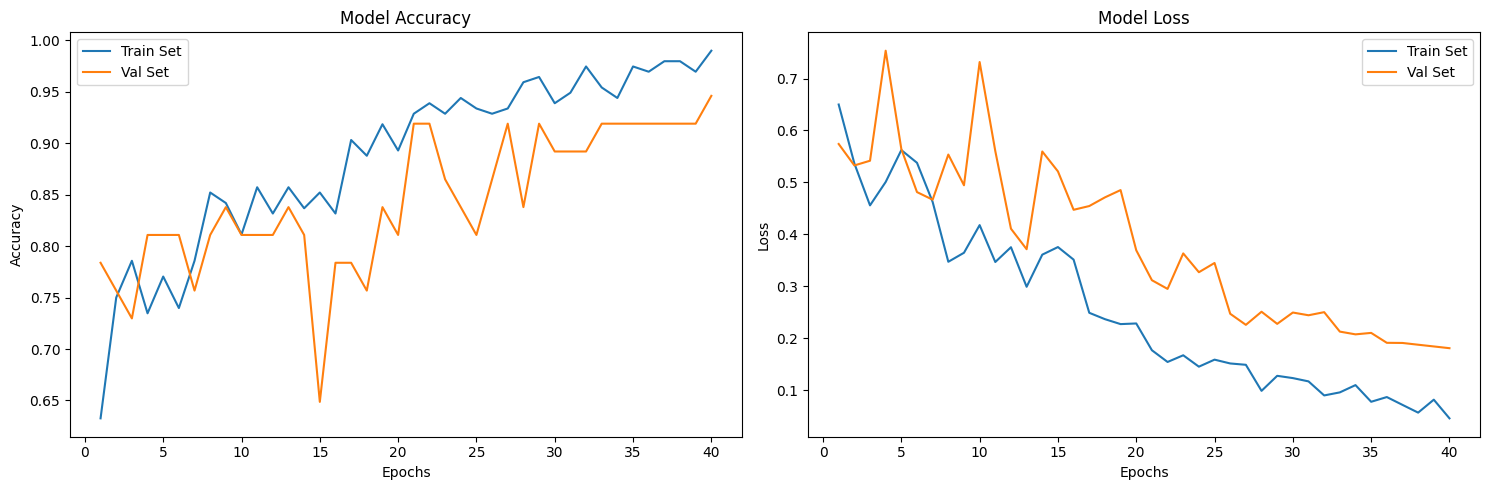

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Test accuracy: 0.95


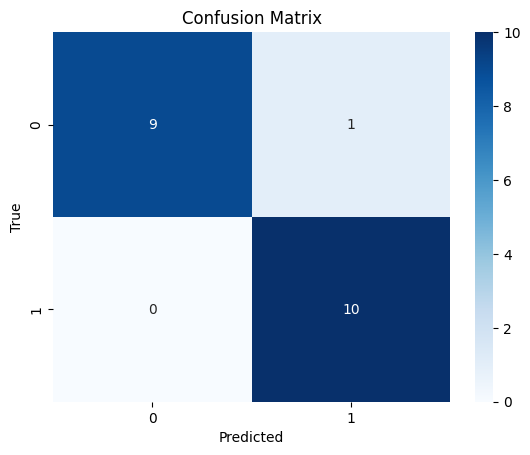

In [65]:
# Y_pred = tf.nn.sigmoid(model.predict(X_test))
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)

test_accuracy = accuracy_score(Y_test, Y_pred)
print('Test accuracy:', test_accuracy)

cm = confusion_matrix(Y_test, Y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [66]:
model.save("brain_tumor.keras")